\begin{center}
Gabe Morris
\end{center}

In [1]:
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from msu_esd import cross_flow_unmixed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from IPython.display import display, Latex

warnings.filterwarnings('ignore', category=FutureWarning)

plt.style.use('../maroon.mplstyle')

\pagebreak
\tableofcontents
\pagebreak

# Given
The preliminary design of a recovery heat exchanger for a Solar Turbines Centaur 50 is to be accomplished. The heat exchanger is to be used to heat water from the turbine exhaust for process use. Surface 8.0-3/8T or surface 9.29-0.737-SR is to be used. More information on the Centaur 50 may be found [here](https://s7d2.scene7.com/is/content/Caterpillar/CM20150703-52095-37893).

The requirements are:

| Property                    | Gas Side    | Water Side  |
|-----------------------------|-------------|-------------|
| $\dot{m}\,(\frac{lbm}{hr})$ | 151,410     | 36,000      |
| $T_{in}\,(^\circ F)$        | 910         | 70          |
| $T_{out}\,(^\circ F)$       | 400         | ?           |
| $P_{in}$                    | atmospheric | atmospheric |

The heat exchanger can have necessary width, but the gas inlet side must be such that the Reynolds number inside the finned-tube is about 1000. Water flows through the tubes, which are manifolded together in such a fashion that the water velocity is 3 ft/sec in order to ensure turbulent flow. The properties of the exhaust gas from the heat recovery are close to the properties of air at the same temperature.

# Find
Select the better surface based on economy of the operation by calculating (a) the heat exchanger width and volume for both surfaces, (b) the gas side pressure drop for both surfaces, and (c) the operating costs for both surfaces for 8760 hr/yr operation. Electricity costs $\frac{\$0.05}{kW\,hr}$ for usage and $\frac{\$9}{kW}$ for demand (per month). The fan is 75% efficient.

The surface selected must be clearly indicated in the report. A sketch of the selected configuration, with dimensions indicated should be included.

# Solution
## Properties
The first step is to acquire the properties of the air and water. The properties may be taken at the average temperature between the inlet and exiting temperatures.

### Air
The average temperature of the air is $655\,^\circ F$. The following properties may be obtained from Table B-2 in the text: $\rho=0.03554\,\frac{lbm}{ft^3}$, $c_p=0.25165\,\frac{Btu}{lbm\,^\circ F}$, $\mu=2.077\cdot10^{-5}\,\frac{lbm}{ft\,sec}$, $Pr=0.68775$.

### Water
For water, the exit temperature is not known, but it may be solved for using an iterative process. First, the rating must be solved for using the known values for the air properties.

In [2]:
# Input parameters of air
mdot_a = 151_410  # lbm/hr
Tin_a = 910  # F
Tout_a = 400  # F
cp_a = 0.25165  # btu/(lbm F)

# Getting the rating
q = mdot_a*cp_a*(Tin_a - Tout_a)
q  # Btu per hour

19432186.514999997

Now the exiting temperature may be solved using some python magic.

In [3]:
# Input parameters of water
mdot_w = 36_000  # lbm/hr
Tin_w = 70  # F

# We can get cp as a function of temperature using an interpolation function from scipy
# From the book,
T_values = [80, 90, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600]
cp_values = [0.998, 0.997, 0.998, 1, 1, 1.01, 1.03, 1.05, 1.08, 1.12, 1.19, 1.31, 1.51]

cp_w_lamb = interp1d(T_values, cp_values, fill_value='extrapolate')

Now `cp_w_lamb` may take in arguments at any temperature. This feature will be used later when accessing the database. For instance, the heat capacity should be between 1.08 and 1.12 for $410\,^\circ F$

In [4]:
float(cp_w_lamb(410))  # adding float() because it returns an array

1.088

Now `fsolve` may be used to iteratively find the outlet temperature.

In [5]:
# Getting the outlet temperature
def get_T(Tout_water):
    T_avg = (Tout_water + Tin_w)/2
    cp_water = float(cp_w_lamb(T_avg))
    return q - mdot_w*cp_water*(Tout_water - Tin_w)  # expression equal to zero

Tout_w = fsolve(get_T, np.array([500, ]))[0]
Tout_w  # F

588.2044624423871

With the average temperature of the water being $329.10223\,^\circ F$, the properties from Table B-2 are: $\rho=56.31\,\frac{lbm}{ft^3}$, $c_p=1.0416\,\frac{Btu}{lbm\,^\circ F}$, $\mu=0.114\cdot10^{-3}\,\frac{lbm}{ft\,sec}$, $Pr=1.087$, $k_w=0.393\,\frac{Btu}{hr\,ft\,^\circ F}$.

## Heat Exchanger Conductance
The heat exchanger conductance may be calculated using the NTU method.

In [6]:
# Calculating the conductance
cp_w = 1.0416  # Btu/(lbm F)

Cc = mdot_w*cp_w  # Btu/(hr F)
Ch = mdot_a*cp_a  # Btu/(hr F)
C_min, C_max = min([Cc, Ch]), max([Cc, Ch])
C = C_min/C_max
print(f'C: {C:.3f}')
q_max = C_min*(Tin_a - Tin_w)  # Btu/hr
eff = q/q_max
print(f'Effectiveness: {eff:.3f}')
ntu = cross_flow_unmixed(eff, C)
UA = ntu*C_min  # Btu/(hr F)
print(f'UA: {UA:.3f} Btu/(hr F)')

C: 0.984
Effectiveness: 0.617
UA: 74166.055 Btu/(hr F)


The conductance of the iteration for the heat exchangers need to match the one calculated above as well as possible.

\begin{center}
\includegraphics{images/fig1}  \\
Figure 1: Fin-Tube Heat Exchanger
\end{center}

The conductance for an iteration depending on the geometry of the heat exchanger may be obtained by calculating the resistances for the air side and water side portions of the heat exchanger. The following relationship is,

$$UA_{iter}=\frac{1}{R_a+R_w}$$

## Surface 9.29-0.737-SR
A graphical representation of the relationship between $Re$ and $StPr^{2/3}$ may be acquired from the database. This relationship will be used to obtain the heat convection coefficient for the airside.

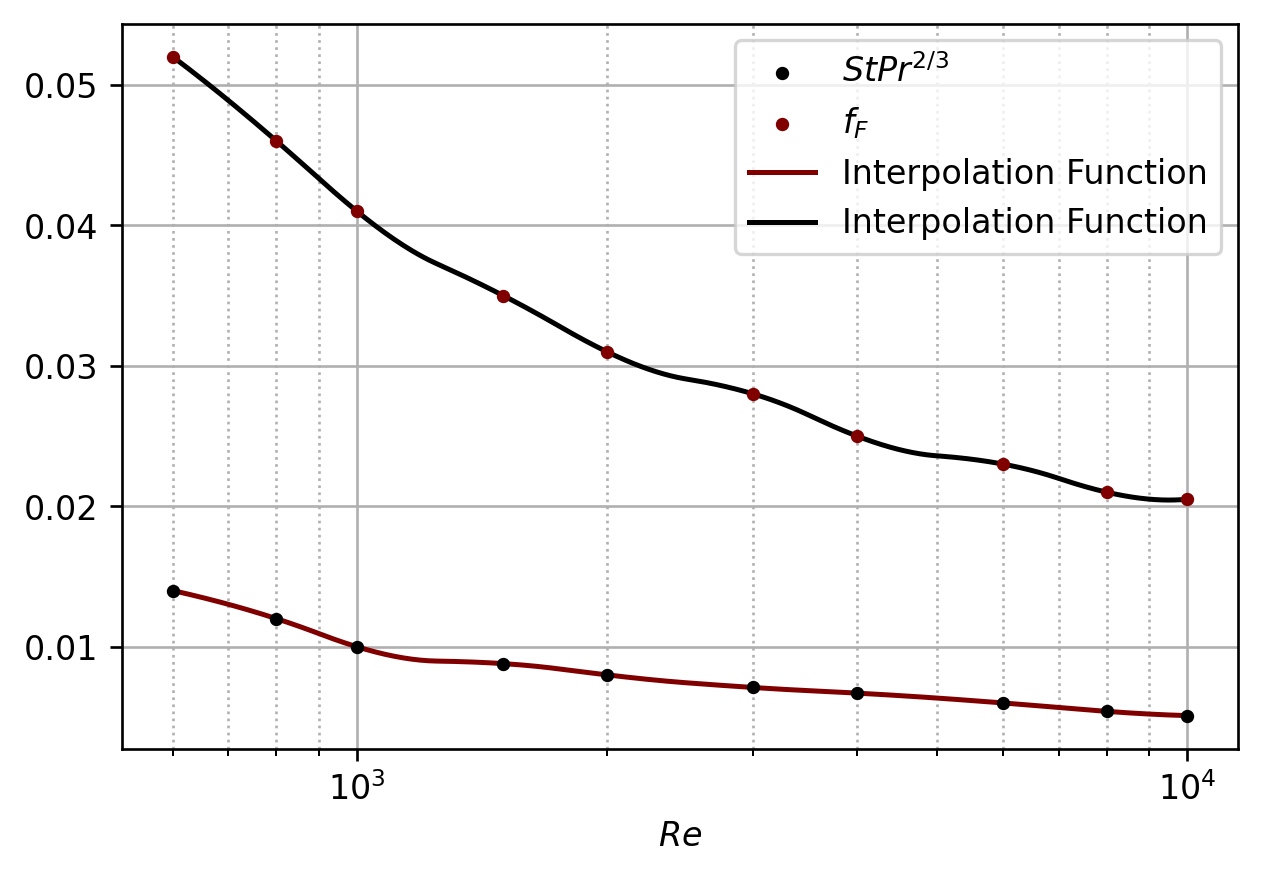

In [7]:
# Getting graph
Re = np.array([600, 800, 1000, 1500, 2000, 3000, 4000, 6000, 8000, 10_000])
hts = np.array([0.014, 0.012, 0.01, 0.0088, 0.008, 0.0071, 0.0067, 0.006, 0.0054, 0.0051])
fF = np.array([0.052, 0.046, 0.041, 0.035, 0.031, 0.028, 0.025, 0.023, 0.021, 0.0205])
hts_lamb = interp1d(Re, hts, kind='quadratic')
fF_lamb = interp1d(Re, fF, kind='quadratic')
Re_values = np.linspace(Re[0], Re[-1], 1000)

plt.scatter(Re, hts, label='$StPr^{2/3}$', zorder=3, marker='.', color='black')
plt.scatter(Re, fF, label='$f_F$', zorder=3, marker='.', color='maroon')
plt.plot(Re_values, hts_lamb(Re_values), label='Interpolation Function', zorder=2)
plt.plot(Re_values, fF_lamb(Re_values), label='Interpolation Function', zorder=2)
plt.xscale('log')
plt.xlabel('$Re$')
plt.grid(which='minor', ls=':')
plt.legend()
plt.show()

| Property                                    | Value                   |
|---------------------------------------------|-------------------------|
| Fin Pitch                                   | 9.29 per inch           |
| Hydraulic Diameter ($D_h$)                  | 0.01352 $ft$            |
| Fin Thickness (Copper)                      | 0.004 $in$              |
| Free flow area/frontal area ($\sigma$)      | 0.788                   |
| Total heat transfer/total volume ($\alpha$) | 228 $\frac{ft^2}{ft^3}$ |
| Fin area/total area                         | 0.814                   |

### Airside
For the airside (fins), the resistance may be found using,

$$R_a=\frac{1}{\eta_tAh_a}$$

The first step is to calculate $Re$ and making sure that it is around 1000.

In [8]:
# Air properties
rho_a = 0.03554 # lbm/ft^3
mu_a = 2.077e-5 # lbm/(ft sec)
cp_a = 0.25165 # Btu/(lbm F)
Pr_a = 0.68775
mdot_a = 151_410/3600 # lbm/sec

# Find the velocity of the air then use that to find Re
N1, N2, N3 = 9, 652, 129
L1 = N1*0.79/12  # ft
L2 = N2*0.108/12  # ft
L3 = N3*0.55/12  # ft
vol = L1*L2*L3 # ft^3
print(f'L1: {L1*12:.3f} in')
print(f'L2: {L2*12:.3f} in')
print(f'L3: {L3*12:.3f} in')
print(f'Volume: {vol:.3f} ft^3')
Da = 0.01352 # ft (from database)
sigma = 0.788 # from database
Va = mdot_a/(L2*L3*sigma*rho_a) # ft/sec
print(f'Velocity: {Va:.3f} ft/s')
G = Va*rho_a
Re_a = G*Da/mu_a
print(f'Re: {Re_a:.3f}')
L1_list, L2_list, L3_list = ['$L_1$ ($in$)', f'{L1*12:.3f}'], [r'$L_2$ ($in$)', f'{L2*12:.3f}'], [r'$L_3$ ($in$)', f'{L3*12:.3f}']
vol_list = ['Volume ($ft^3$)', f'{vol:.3f}']
air_vel_list = [r'Air Velocity ($\frac{ft^3}{s}$)', f'{Va:.3f}']
air_re_list = ["Airside Reynold's", f'{Re_a:.3f}']

L1: 7.110 in
L2: 70.416 in
L3: 70.950 in
Volume: 20.557 ft^3
Velocity: 43.286 ft/s
Re: 1001.394


With $Re$ known, the convection may now be solved using,

$$StPr^{2/3}=\frac{h}{G\cdot c_{p,a}}Pr^{2/3}\rightarrow h=\frac{StPr^{2/3}\cdot G\cdot c_{p,a}}{Pr^{2/3}}$$

In [9]:
h_a = hts_lamb(Re_a)*G*cp_a/(Pr_a**(2/3))
h_a  # Btu/(s ft^2 F)

0.004963260658832816

The total fin efficiency may be determined using,

$$\eta_t=1-\frac{A_{fin}}{A_{tot}}(1-\eta_{fin})$$

In [10]:
alpha = 228 # ft^2/ft^3
A_ratio = 0.814
A = alpha*vol # ft^2
L_fin = 0.01875 # ft
k_fin = 221/3600 # Btu/(sec ft F)
t_fin = 0.004/12 # ft
m = np.sqrt(h_a*2/(k_fin*t_fin))
eta_fin = np.tanh(m*L_fin)/(m*L_fin)
print(f'Fin Efficiency: {eta_fin:.3f}')
eta_t = 1 - A_ratio*(1 - eta_fin)
print(f'Total Efficiency: {eta_t:.3f}')
R_fin = 1/(eta_t*A*h_a)
print(f'Resistance: {R_fin:.3f} sec F/Btu')

Fin Efficiency: 0.947
Total Efficiency: 0.957
Resistance: 0.045 sec F/Btu


### Waterside
The resistance from the waterside may be acquired by using,

$$R_w=\frac{1}{h_wA_c}$$

$Re$ may be found first after acquiring the hydraulic diameter, then that could be used to calculate $Nu$. The convection coefficient can then be found using,

$$h_w=\frac{Nu\cdot k_w}{D_h}$$

\begin{center}
\includegraphics{images/fig2} \\
Figure 2: Known Tube Geometry
\end{center}

In [11]:
# Water properties
rho_w = 56.31  # lbm/ft^3
cp_w = 1.0416  # btu/(lbm F)
mu_w = 0.114e-3  # lbm/(ft sec)
Pr_w = 1.087
k_w = 0.393/3600  # btu/(sec ft F)

Dc = 4*0.00306  # ft (from example 3-3)
alpha_c = 42.1  # ft^2/ft^3 (from example 3-3)
sigma_c = 0.129
Vw = 3  # ft/sec
Gw = Vw*rho_w  # lbm/(s ft^2)
Re_w = Gw*Dc/mu_w
print(f"Re: {Re_w:.3f}")
water_re_list = [f'{Re_w:.3f}']

Re: 18137.747


In [12]:
# Since the flow is turbulent,
Nu = 0.023*Re_w**0.8*Pr_w**0.333
print(f'Nu: {Nu:.3f}')
h_w = Nu*k_w/Dc
print(f'h: {h_w:.3f} Btu/(s ft^2 F)')
Ac = alpha_c*vol
print(f'Ac: {Ac:.3f} ft^2')
Rw = 1/(Ac*h_w)
print(f'Resistance: {Rw} F*sec/Btu')

Nu: 60.347
h: 0.538 Btu/(s ft^2 F)
Ac: 865.430 ft^2
Resistance: 0.0021468450780435682 F*sec/Btu


In [13]:
# Solving for UA_iter
UA_iter = 1/(Rw + R_fin)*3600
print(f'UA_iter: {UA_iter:.3f} Btu/(hr F)')
print(f'UA_iter/UA: {UA_iter/UA:.3f}')

UA_iter: 76463.029 Btu/(hr F)
UA_iter/UA: 1.031


Thus, the final dimensions of the heat exchanger are $L_1=7.110\,in$ (width), $L_2=70.416\,in$, and $L_3=70.950\,in$. One important criteria to consider when determining the lengths is that the number of fins and tubes have to be an integer because part of a fin or tube cannot exist. This means that $N$ in the relationships below for $L_1$, $L_2$, and $L_3$ must be an integer.

$$0.79\cdot N_1=L_1$$
$$0.108\cdot N_2=L_2$$
$$0.55\cdot N_3=L_3$$

The 0.108 above is the reciprocal of the fin pitch $\left(\frac{1}{9.29\,in}=0.108\,in\right)$.

The distances calculated above do follow this physical limitation. This limitation also means that $L_2$ can never be equal to $L_3$ because $N=0$ is the only solution to that system.

Also, property corrections are ignored for this analysis due to the differences being negligible. Property corrections are for highly viscous fluids, and this is water and air.

### Airside Pressure Drop
The relationship for the pressure drop is,

$$\Delta P=\frac{G^2}{2\rho_{a,in}}\left[(K_c+1-\sigma^2)+2\left(\frac{\rho_{a,in}}{\rho_{a,out}}-1\right)+f_F\frac{A}{A_c}\frac{\rho_{a,in}}{\rho_{a,mean}}-(1-\sigma^2-K_e)\frac{\rho_{a,in}}{\rho_{a,out}}\right]$$

\begin{center}
\includegraphics{images/fig3} \\
Figure 3: $K_c$ and $K_e$
\end{center}

The constants $K_c$ and $K_e$ may be acquired from Figure 3. Although the curves above are for flat-duct heat exchangers, the assumption is that surface 9.29-0.737-SR is similar.

In [14]:
# Obtain air properties
rho_a_in = 0.0289  # lbm/ft^3 at 910 F
rho_a_out = 0.046  # lbm/ft^3 at 400 F
rat = rho_a_in/rho_a_out

# From figure above
Kc, Ke = 0.59, -0.23

x1 = Kc + 1 - sigma**2
x2 = 2*(rat - 1)
x3 = float(fF_lamb(Re_a))*A/(L2*L3*sigma)*rho_a_in/rho_a
x4 = (1 - sigma**2 - Ke)*rat

del_P = G**2/(2*rho_a_in)*(x1 + x2 + x3 - x4)/32.174
pressure_list = [r'$\Delta P$ ($\frac{lbf}{ft^2}$)', f'{del_P:.3f}']
del_P  # lbf/ft^2

7.068685332750924

Thus, the pressure drop across the airside is around $7.07\,\frac{lbf}{ft^2}$.

### Power Consumption
The power consumption for the fan may be calculating using,

$$power=\frac{Q\Delta P}{\eta}$$

where $\eta$ is the efficiency and $Q=\frac{\dot{m}}{\rho}$.

In [15]:
# Calculating the power
eta = 0.75
Q_a = mdot_a/rho_a  # ft^3/s
power = Q_a*del_P/eta
power_kW = power*0.00135581795
print(f'Power: {power:.3f} ft*lbf/s = {power/550:.3f} hp = {power_kW:.3f} kW')
power_list = ['Airside Power ($hp$)', f'{power/550:.3f}']

Power: 11153.522 ft*lbf/s = 20.279 hp = 15.122 kW


The relationship for power and cost is,

$$cost\ per\ year=\frac{\$0.05}{kW\,hr}\frac{8760\,hr}{yr}\cdot power+\frac{\$9}{kW\,mo}\frac{12\,mo}{yr}\cdot power$$

where the power is in kilowatts.

In [16]:
# Calculating the cost per year
cost_per_year = 0.05*8760*power_kW + 9*12*power_kW
print(f'Cost Per Year: ${cost_per_year:.2f}/year')
cost_list = ['Annual Cost', f'{cost_per_year:.2f}']

Cost Per Year: $8256.69/year


The operating cost of the 9.29-0.737-SR surface is $8256.69/year.

## Surface 8.0-3/8T
The process above may be copied with different values from the database.

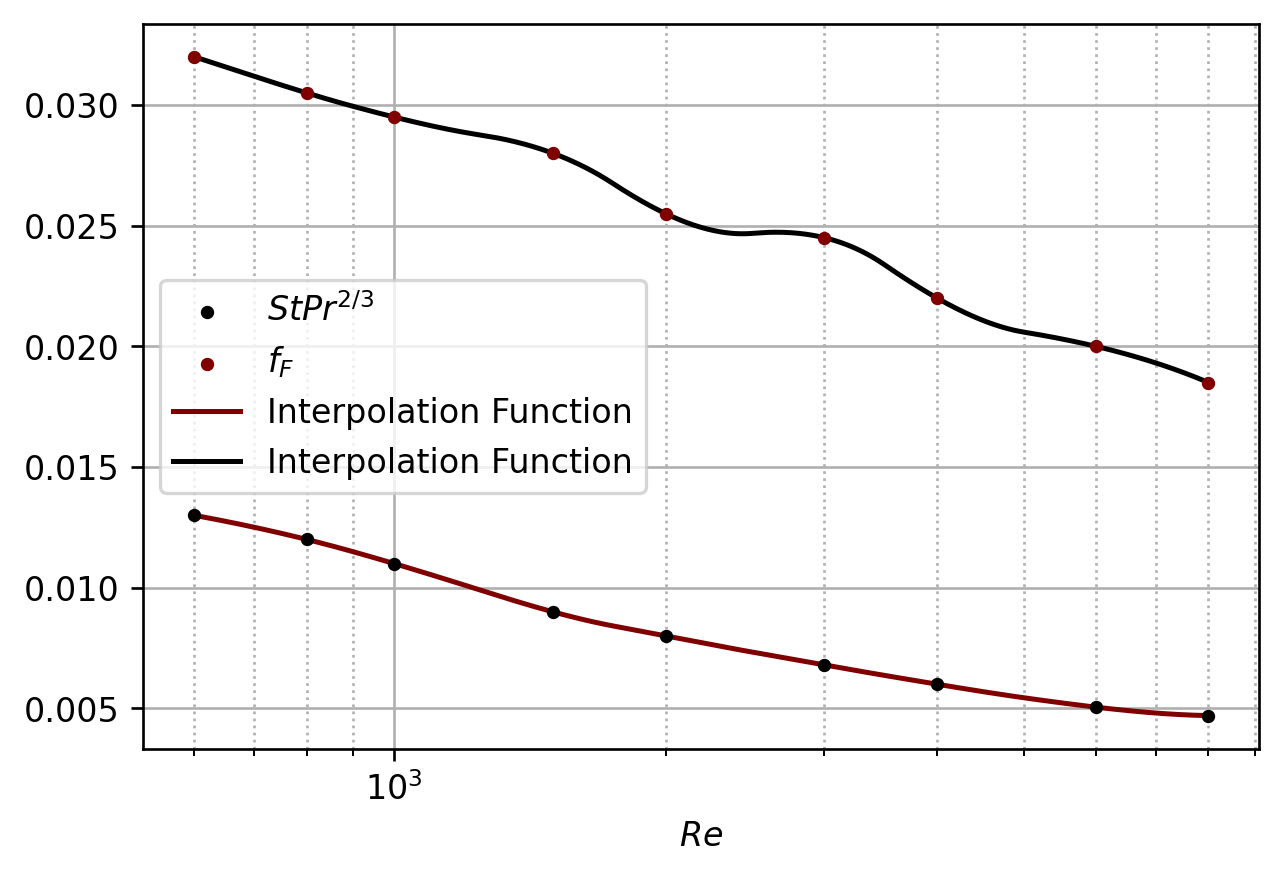

In [17]:
# Getting graph
Re = np.array([600, 800, 1000, 1500, 2000, 3000, 4000, 6000, 8000])
hts = np.array([0.013, 0.012, 0.011, 0.009, 0.008, 0.0068, 0.006, 0.00505, 0.0047])
fF = np.array([0.032, 0.0305, 0.0295, 0.028, 0.0255, 0.0245, 0.022, 0.02, 0.0185])
hts_lamb = interp1d(Re, hts, kind='quadratic')
fF_lamb = interp1d(Re, fF, kind='quadratic')
Re_values = np.linspace(Re[0], Re[-1], 1000)

plt.scatter(Re, hts, label='$StPr^{2/3}$', zorder=3, marker='.', color='black')
plt.scatter(Re, fF, label='$f_F$', zorder=3, marker='.', color='maroon')
plt.plot(Re_values, hts_lamb(Re_values), label='Interpolation Function', zorder=2)
plt.plot(Re_values, fF_lamb(Re_values), label='Interpolation Function', zorder=2)
plt.xscale('log')
plt.xlabel('$Re$')
plt.grid(which='minor', ls=':')
plt.legend()
plt.show()

| Property                                    | Value                   |
|---------------------------------------------|-------------------------|
| Tube outside diameter                       | 0.402 $in$              |
| Fin Pitch                                   | 8 per inch              |
| Hydraulic Diameter ($D_h$)                  | 0.01192 $ft$            |
| Fin Thickness (Copper)                      | 0.013 $in$              |
| Free flow area/frontal area ($\sigma$)      | 0.534                   |
| Total heat transfer/total volume ($\alpha$) | 179 $\frac{ft^2}{ft^3}$ |
| Fin area/total area                         | 0.913                   |

### Airside

In [18]:
# Find the velocity of the air then use that to find Re
N1, N2, N3 = 7, 642, 81
L1 = 0.866*N1/12  # ft
L2 = 0.125*N2/12  # ft
L3 = 1.000*N3/12  # ft
vol = L1*L2*L3 # ft^3
print(f'L1: {L1*12:.3f} in')
print(f'L2: {L2*12:.3f} in')
print(f'L3: {L3*12:.3f} in')
print(f'Volume: {vol:.3f} ft^3')
Da = 0.01192 # ft (from database)
sigma = 0.534 # from database
Va = mdot_a/(L2*L3*sigma*rho_a) # ft/sec
print(f'Velocity: {Va:.3f} ft/s')
G = Va*rho_a
Re_a = G*Da/mu_a
print(f'Re: {Re_a:.3f}')
L1_list.append(f'{L1*12:.3f}')
L2_list.append(f'{L2*12:.3f}')
L3_list.append(f'{L3*12:.3f}')
vol_list.append(f'{vol:.3f}')
air_vel_list.append(f'{Va:.3f}')
air_re_list.append(f'{Re_a:.3f}')

L1: 6.062 in
L2: 80.250 in
L3: 81.000 in
Volume: 22.804 ft^3
Velocity: 49.094 ft/s
Re: 1001.343


In [19]:
h_a = hts_lamb(Re_a)*G*cp_a/(Pr_a**(2/3))
h_a  # Btu/(s ft^2 F)

0.006195232269876673

In [20]:
alpha = 179 # ft^2/ft^3
A_ratio = 0.913
A = alpha*vol # ft^2
L_fin = (1 - 0.402)/2/12 # ft
k_fin = 221/3600 # Btu/(sec ft F) assuming copper
t_fin = 0.013/12 # ft
m = np.sqrt(h_a*2/(k_fin*t_fin))
eta_fin = np.tanh(m*L_fin)/(m*L_fin)
print(f'Fin Efficiency: {eta_fin:.3f}')
eta_t = 1 - A_ratio*(1 - eta_fin)
print(f'Total Efficiency: {eta_t:.3f}')
R_fin = 1/(eta_t*A*h_a)
print(f'Resistance: {R_fin:.3f} sec F/Btu')

Fin Efficiency: 0.963
Total Efficiency: 0.966
Resistance: 0.041 sec F/Btu


\begin{center}
\includegraphics[scale=0.75]{images/fig4} \\
Figure 4: Surface 8.0-3/8T Tube Geometry
\end{center}

Assuming that the thickness of the tube is negligible, the hydraulic diameter of the tube is the diameter $D_c=0.402\,in$, since the geometry is circular. The contraction ratio, $\sigma$, is the cross-sectional area divided by the repeating pattern area.

$$\sigma_c=\frac{\frac{\pi}{4}\cdot0.402^2}{1\cdot0.866}=0.147$$

The heat transfer area is $A_c=\alpha_c\cdot V$, where $\alpha_c$ is the surface area density, which is the surface area inside the tubes divided by the repeating pattern volume. If a $1\,in$ chunk of the pattern is considered, the surface area density is,

$$\alpha_c=\frac{\pi\cdot0.402\,in\cdot1\,in}{1\,in\cdot\,0.866\,in\cdot\,1\,in}=1.458\,\frac{in^2}{in^3}=17.5\frac{ft^2}{ft^3}$$

### Waterside

In [21]:
Dc = 0.402/12  # ft
alpha_c = 17.5  # ft^2/ft^3
# sigma_c = (np.pi/4*0.402**2)/0.866
Vw = 3  # ft/sec
Gw = Vw*rho_w  # lbm/(s ft^2)
Re_w = Gw*Dc/mu_w
print(f"Re: {Re_w:.3f}")
water_re_list.append(f'{Re_w:.3f}')

Re: 49641.711


In [22]:
# Since the flow is turbulent,
Nu = 0.023*Re_w**0.8*Pr_w**0.333
print(f'Nu: {Nu:.3f}')
h_w = Nu*k_w/Dc
print(f'h: {h_w:.3f} Btu/(s ft^2 F)')
Ac = alpha_c*vol
print(f'Ac: {Ac:.3f} ft^2')
Rw = 1/(Ac*h_w)
print(f'Resistance: {Rw} F*sec/Btu')

Nu: 135.042
h: 0.440 Btu/(s ft^2 F)
Ac: 399.062 ft^2
Resistance: 0.005694358302286273 F*sec/Btu


In [23]:
# Solving for UA_iter
UA_iter = 1/(Rw + R_fin)*3600
print(f'UA_iter: {UA_iter:.3f} Btu/(hr F)')
print(f'UA_iter/UA: {UA_iter/UA:.3f}')

UA_iter: 77227.046 Btu/(hr F)
UA_iter/UA: 1.041


Thus, the final dimensions of the heat exchanger are $L_1=6.062\,in$, $L_2=80.250\,in$, and $L_3=81\,in$. Looking at Figure 4, the limitations are,

$$0.866\cdot N_1=L_1$$
$$0.125\cdot N_2=L_2$$
$$1.000\cdot N_3=L_3$$

### Airside Pressure Drop
An important part of calculating the pressure drop is determining the $K_c$ and $K_e$ values. According to W.M. Kays and A.L. London's *Compact Heat Exchangers*, the less developed the fluid should have $K_c$ values that are lower than $K_c$ values for a fully developed flow (meaning viscous effects are present), and $K_e$ values should be higher for the less developed flows (p. 110). The entrance length for this scenario is $L_H=0.05(1000)(0.01192)=0.596\,ft=7.152\,in$, which is greater than the width for which the air travels ($L_1$). This means that the flow is not fully developed.

\begin{center}
\includegraphics{images/fig5} \\
Figure 5: $K_c$ and $K_e$ for Circular Tubes
\end{center}

Because the flow is in the inviscid region, a less conservative line from the plot in Figure 5 was chosen.

In [24]:
# From figure above
Kc, Ke = 0.8, -0.1

x1 = Kc + 1 - sigma**2
x2 = 2*(rat - 1)
x3 = float(fF_lamb(Re_a))*A/(L2*L3*sigma)*rho_a_in/rho_a
x4 = (1 - sigma**2 - Ke)*rat

del_P = G**2/(2*rho_a_in)*(x1 + x2 + x3 - x4)/32.174
pressure_list.append(f'{del_P:.3f}')
del_P  # lbf/ft^2

7.073175777076184

Thus, the pressure drop across the airside is $7.07\,\frac{lbf}{ft^2}$.

### Power Consumption

In [25]:
# Calculating the power
eta = 0.75
Q_a = mdot_a/rho_a  # ft^3/s
power = Q_a*del_P/eta
power_kW = power*0.00135581795
print(f'Power: {power:.3f} ft*lbf/s = {power/550:.3f} hp = {power_kW:.3f} kW')
power_list.append(f'{power/550:.3f}')

Power: 11160.607 ft*lbf/s = 20.292 hp = 15.132 kW


In [26]:
 # Calculating the cost per year
cost_per_year = 0.05*8760*power_kW + 9*12*power_kW
print(f'Cost Per Year: ${cost_per_year:.2f}/year')
cost_list.append(f'{cost_per_year:.2f}')

Cost Per Year: $8261.94/year


Thus, the operating cost of the 8.0-3/8T surface is $8261.94/year.

# Results and Discussion

In [27]:
# Generating table
data = [
    L1_list,
    L2_list,
    L3_list,
    vol_list,
    air_vel_list,
    air_re_list,
    pressure_list,
    power_list,
    cost_list
]
index = [row[0] for row in data]
df = pd.DataFrame([row[1:] for row in data], columns=['9.29-0.737-SR', '8.0-3/8T'], index=index)
# df
display(Latex(fr'\begin{{center}}{df.to_latex(escape=False)}\end{{center}}'))

<IPython.core.display.Latex object>

The table above shows a summary of the calculated results. Some key takeaways are,

1. The volume for the 8.0-3/8T heat exchanger is greater than the 9.29-0.737-SR, thus, taking up more space overall.
2. The 8.0-3/8T heat exchanger has the smaller width, $L_1$.
3. The 9.29-0.737-SR heat exchanger is slightly more cost-efficient.

Given the following above, the heat exchanger to select should be the 8.0-3/8T because it is thinner. Although the 8.0-3/8T is more expensive, the cost difference is within 0.1%, making the cost not substantial enough to justify the selection alone. The real advantage for the 8.0-3/8T is that it can fit in narrower spaces. This, however, is only useful if the space has a length long enough to fit the $81"\times80.25"$ square surface, which is assumed to be present along the Centaur 50 given the size of the system shown in Figure 6.

\begin{center}
\includegraphics{images/fig6} \\
Figure 6: Enclosure Access and Maintenance Space
\end{center}

From Figure 6, notice that the height of the system is 10'5" (out of the page), and the width is 8'6". This is sufficient space to fit the larger $81"\times80.25"$ square of the 8.0-3/8T heat exchanger, but also decrease the length of the system compared to the 9.29-0.737-SR. This logic, however, is only valid if the heat exchanger can be positioned in such a way that the $L_1$ direction is parallel to the 32'3" direction in Figure 6.

# Design

\begin{center}
\includegraphics{images/fig7} \\
Figure 7: Heat Exchanger Drawing
\end{center}

Figure 7 shows the layout of the surface 8.0-3/8T pattern. Notice that the holes are staggered, but the pattern shown in Figure 4 still persists. The thickness of the tube is not known, but is assumed to be negligible.

\begin{center}
\includegraphics{images/fig8}
\end{center}